# PDF to text

## [deepdoc](https://github.com/infiniflow/ragflow/tree/main/deepdoc)

`pip install -r requirements.txt`

In [ ]:
import fitz
import numpy as np
from PIL import Image

filename = "./workspace/0700_2023.pdf"
zoomin = 3
mat = fitz.Matrix(zoomin, zoomin)

pdf = fitz.open(filename)
for i, page in enumerate(pdf):
    pix = page.get_pixmap(matrix=mat)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    if i == 20:
        break

img

### OCR (原理展示，可跳过)

In [2]:
from pdf_utils.deepdoc import OCR

ocr = OCR()
bxs = ocr(np.array(img))
bxs

2024-04-11 14:53:16.599 | DEBUG    | pdf_utils.deepdoc.ocr:__call__:609 - dt_boxes num : 81, elapsed : 0.11179280281066895
2024-04-11 14:53:18.935 | DEBUG    | pdf_utils.deepdoc.ocr:__call__:624 - rec_res num  : 81, elapsed : 2.315112829208374


[([[170.0, 149.0], [553.0, 149.0], [553.0, 199.0], [170.0, 199.0]],
  ('管理層讨及分析', 0.9555755853652954)),
 ([[170.0, 384.0], [637.0, 384.0], [637.0, 419.0], [170.0, 419.0]],
  ('非國際财務報告财務计量', 0.718015730381012)),
 ([[173.0, 467.0], [1619.0, 467.0], [1619.0, 500.0], [173.0, 500.0]],
  ('為補充根據國際财務報告则製的本集團综合業；若干外的非國際財務報告则財務計量(經營盈利丶經營利', 0.8842271566390991)),
 ([[170.0, 520.0], [1616.0, 520.0], [1616.0, 556.0], [170.0, 556.0]],
  ('潤率丶期内盈利丶純利率丶本公司權益持有人應占盈利丶每股基本盈利及每股薄盈利)已於本年報内呈列。此等未', 0.9556125402450562)),
 ([[170.0, 576.0], [1611.0, 576.0], [1611.0, 609.0], [170.0, 609.0]],
  ('經核非國際財務報告则財務计量應被視為根據國際財務報告则製的本集團財務業的補充而非替代计量。', 0.8745207786560059)),
 ([[167.0, 629.0], [1307.0, 629.0], [1307.0, 662.0], [167.0, 662.0]],
  ('此外，此等非國際財務報告则财務計量的定義可能與其他公司所用的類似有所不同。', 0.923906147480011)),
 ([[170.0, 737.0], [1616.0, 737.0], [1616.0, 770.0], [170.0, 770.0]],
  ('本公司的管理層相信；非國際財務報告则财務計量藉排除若干非現金目及投資相關交易的若干影響為投資者', 0.9274271130561829)),
 ([[170.0, 790.0], [1616.0, 790.0], [1616.0, 826.0], [170.0, 826.0]],


In [3]:
# 提取识别区域信息
bxs = [(line[0], line[1][0]) for line in bxs]
bxs = [{
    "text": t,
    "bbox": [b[0][0], b[0][1], b[1][0], b[-1][1]],
    "type": "ocr",
    "score": 1} for b, t in bxs if b[0][0] <= b[1][0] and b[0][1] <= b[-1][1]]
bxs

[{'text': '管理層讨及分析',
  'bbox': [170.0, 149.0, 553.0, 199.0],
  'type': 'ocr',
  'score': 1},
 {'text': '非國際财務報告财務计量',
  'bbox': [170.0, 384.0, 637.0, 419.0],
  'type': 'ocr',
  'score': 1},
 {'text': '為補充根據國際财務報告则製的本集團综合業；若干外的非國際財務報告则財務計量(經營盈利丶經營利',
  'bbox': [173.0, 467.0, 1619.0, 500.0],
  'type': 'ocr',
  'score': 1},
 {'text': '潤率丶期内盈利丶純利率丶本公司權益持有人應占盈利丶每股基本盈利及每股薄盈利)已於本年報内呈列。此等未',
  'bbox': [170.0, 520.0, 1616.0, 556.0],
  'type': 'ocr',
  'score': 1},
 {'text': '經核非國際財務報告则財務计量應被視為根據國際財務報告则製的本集團財務業的補充而非替代计量。',
  'bbox': [170.0, 576.0, 1611.0, 609.0],
  'type': 'ocr',
  'score': 1},
 {'text': '此外，此等非國際財務報告则财務計量的定義可能與其他公司所用的類似有所不同。',
  'bbox': [167.0, 629.0, 1307.0, 662.0],
  'type': 'ocr',
  'score': 1},
 {'text': '本公司的管理層相信；非國際財務報告则财務計量藉排除若干非現金目及投資相關交易的若干影響為投資者',
  'bbox': [170.0, 737.0, 1616.0, 770.0],
  'type': 'ocr',
  'score': 1},
 {'text': '估本集團核心業務的業提供有用的補充資料。此外，非國際财務報告则調整包括本集團主要聯營公司的相關非',
  'bbox': [170.0, 790.0, 1616.0, 826.0],
  'type': 'ocr',
  'score': 1},
 {'text': '國際財務

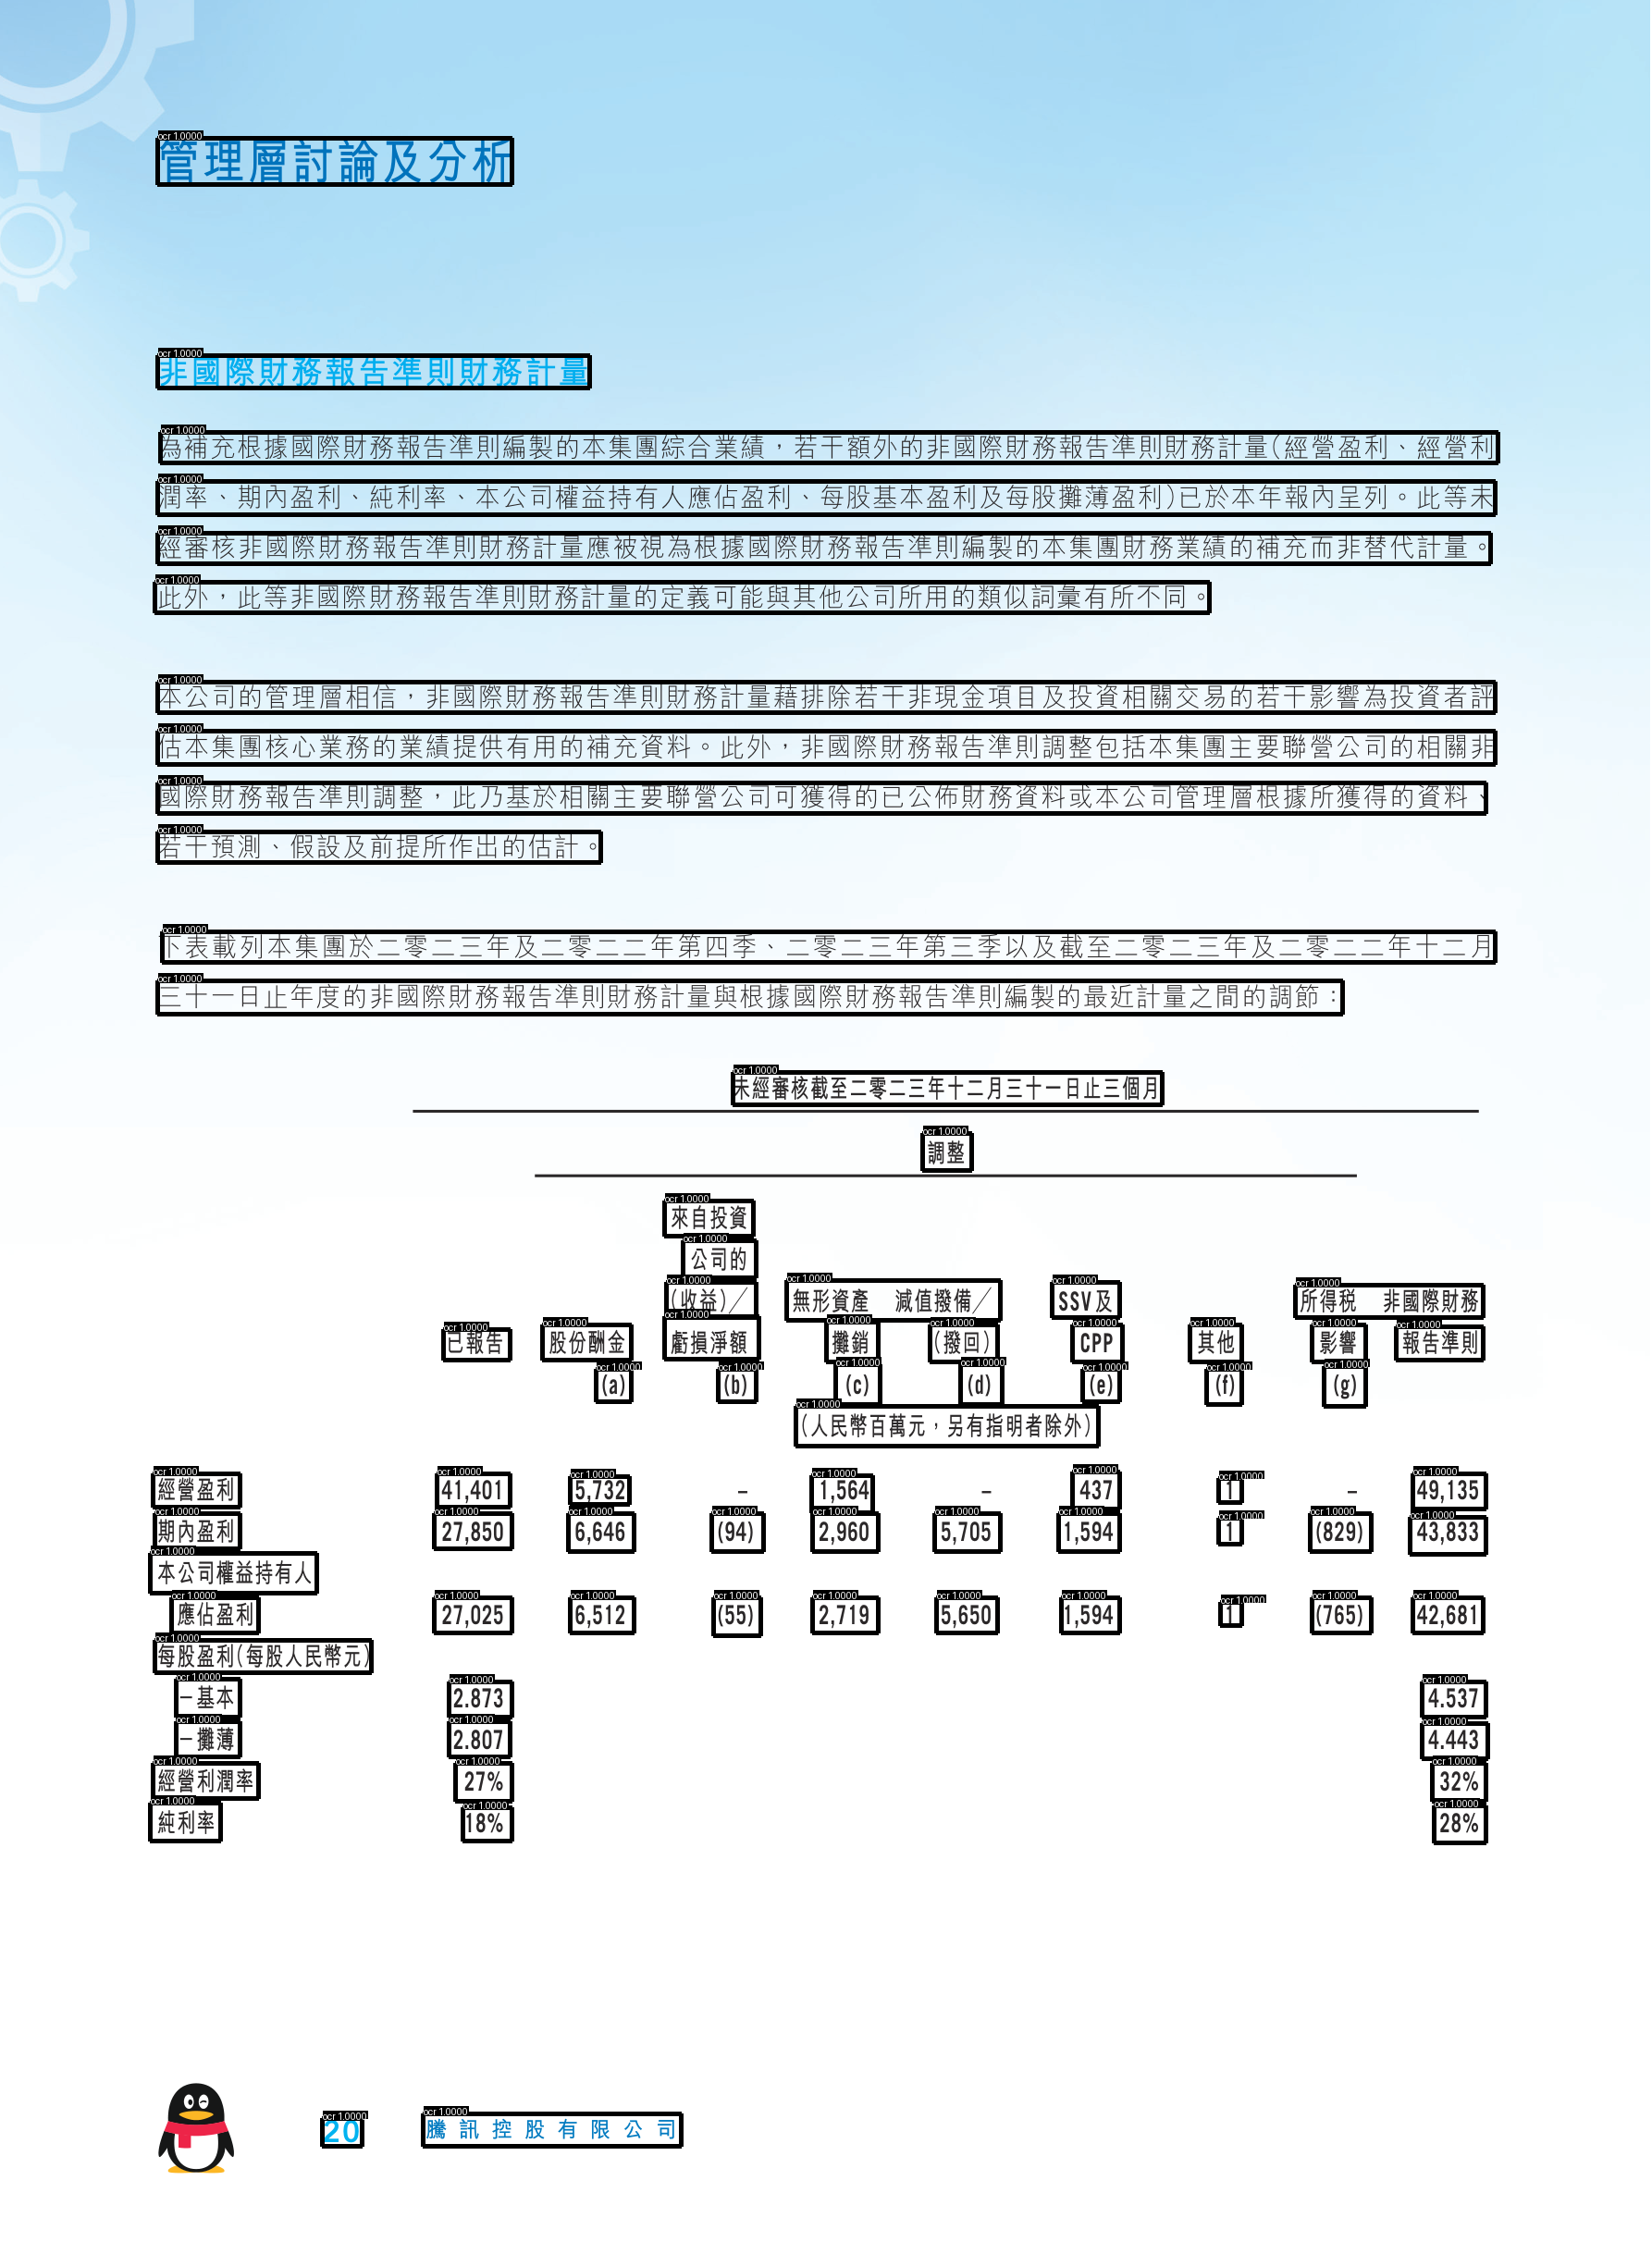

In [4]:
from pdf_utils.deepdoc.seeit import draw_box

img_draw = draw_box(img, bxs, ["ocr"], 1.)
img_draw

### 表格识别

In [3]:
from pdf_utils.deepdoc import OCR, TableStructureRecognizer

ocr = OCR()
labels = TableStructureRecognizer.labels
detr = TableStructureRecognizer()

threshold = 0.5
layouts = detr([img], float(threshold))
layouts

preprocess


[[{'label': 'table',
   'score': 0.8828529119491577,
   'x0': 0.822998046875,
   'x1': 1611.63916015625,
   'top': 0.48724365234375,
   'bottom': 939.8701782226562},
  {'label': 'table',
   'score': 0.8339587450027466,
   'x0': 3.1668701171875,
   'x1': 1599.2691650390625,
   'top': 1203.053466796875,
   'bottom': 2324.887939453125},
  {'label': 'table column',
   'score': 0.862404465675354,
   'x0': 566.5874633789062,
   'x1': 701.1608276367188,
   'top': 1201.510009765625,
   'bottom': 2414.095703125},
  {'label': 'table column',
   'score': 0.8623781800270081,
   'x0': 699.0255126953125,
   'x1': 834.6549072265625,
   'top': 1201.510009765625,
   'bottom': 2410.535888671875},
  {'label': 'table column',
   'score': 0.8469351530075073,
   'x0': 1479.764892578125,
   'x1': 1597.94091796875,
   'top': 1195.19921875,
   'bottom': 2428.148193359375},
  {'label': 'table column',
   'score': 0.834102988243103,
   'x0': 833.2890014648438,
   'x1': 955.6670532226562,
   'top': 1201.510009765

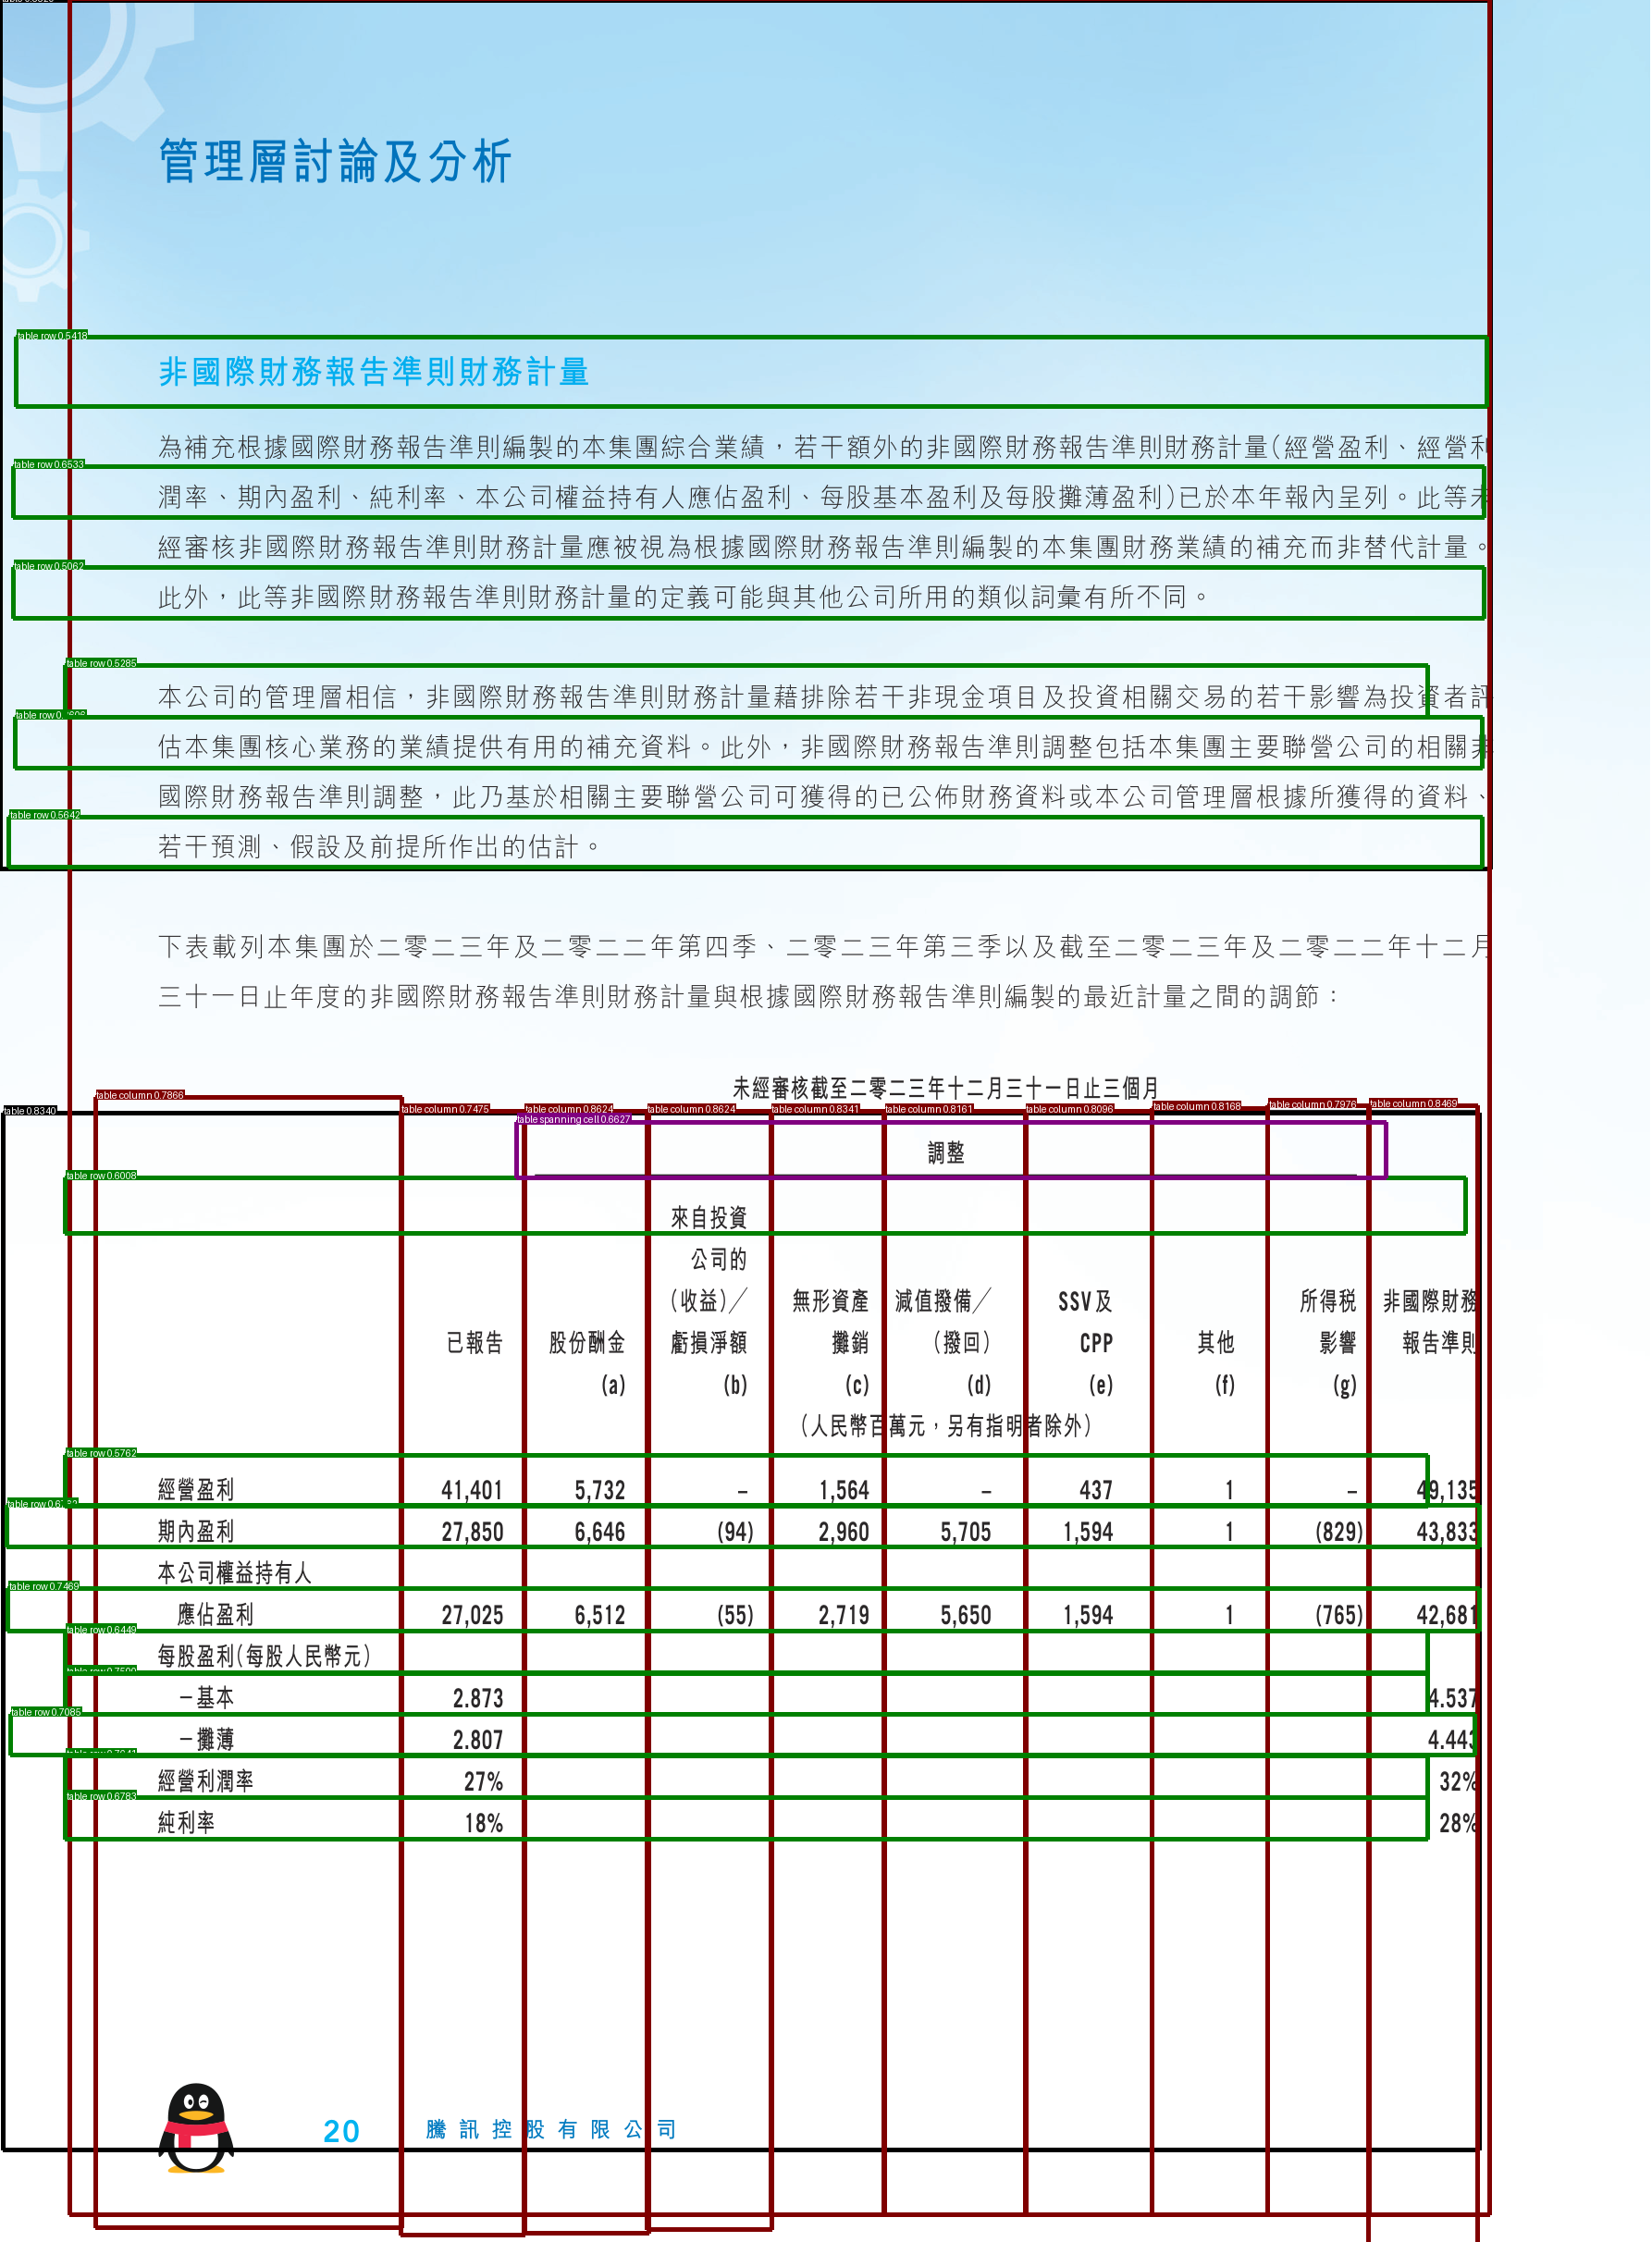

In [4]:
from pdf_utils.deepdoc.seeit import draw_box

layout_draw = [{
    "type": t["label"],
    "bbox": [t["x0"], t["top"], t["x1"], t["bottom"]],
    "score": t["score"]
} for t in layouts[0]]

img_table = draw_box(img, layout_draw, labels, float(threshold))
img_table

In [ ]:
import re
from pdf_utils.deepdoc import Recognizer

def get_table_html(img, tb_cpns, ocr):
    boxes = ocr(np.array(img))
    boxes = Recognizer.sort_Y_firstly(
        [{"x0": b[0][0], "x1": b[1][0],
          "top": b[0][1], "text": t[0],
          "bottom": b[-1][1],
          "layout_type": "table",
          "page_number": 0} for b, t in boxes if b[0][0] <= b[1][0] and b[0][1] <= b[-1][1]],
        np.mean([b[-1][1] - b[0][1] for b, _ in boxes]) / 3
    )

    def gather(kwd, fzy=10, ption=0.6):
        nonlocal boxes
        eles = Recognizer.sort_Y_firstly(
            [r for r in tb_cpns if re.match(kwd, r["label"])], fzy)
        eles = Recognizer.layouts_cleanup(boxes, eles, 5, ption)
        return Recognizer.sort_Y_firstly(eles, 0)

    headers = gather(r".*header$")
    rows = gather(r".* (row|header)")
    spans = gather(r".*spanning")
    clmns = sorted([r for r in tb_cpns if re.match(
        r"table column$", r["label"])], key=lambda x: x["x0"])
    clmns = Recognizer.layouts_cleanup(boxes, clmns, 5, 0.5)

    for b in boxes:
        ii = Recognizer.find_overlapped_with_threashold(b, rows, thr=0.3)
        if ii is not None:
            b["R"] = ii
            b["R_top"] = rows[ii]["top"]
            b["R_bott"] = rows[ii]["bottom"]

        ii = Recognizer.find_overlapped_with_threashold(b, headers, thr=0.3)
        if ii is not None:
            b["H_top"] = headers[ii]["top"]
            b["H_bott"] = headers[ii]["bottom"]
            b["H_left"] = headers[ii]["x0"]
            b["H_right"] = headers[ii]["x1"]
            b["H"] = ii

        ii = Recognizer.find_horizontally_tightest_fit(b, clmns)
        if ii is not None:
            b["C"] = ii
            b["C_left"] = clmns[ii]["x0"]
            b["C_right"] = clmns[ii]["x1"]

        ii = Recognizer.find_overlapped_with_threashold(b, spans, thr=0.3)
        if ii is not None:
            b["H_top"] = spans[ii]["top"]
            b["H_bott"] = spans[ii]["bottom"]
            b["H_left"] = spans[ii]["x0"]
            b["H_right"] = spans[ii]["x1"]
            b["SP"] = ii

    html = """
    <html>
    <head>
    <style>
    ._table_1nkzy_11 {
      margin: auto;
      width: 70%%;
      padding: 10px;
    }
    ._table_1nkzy_11 p {
      margin-bottom: 50px;
      border: 1px solid #e1e1e1;
    }

    caption {
      color: #6ac1ca;
      font-size: 20px;
      height: 50px;
      line-height: 50px;
      font-weight: 600;
      margin-bottom: 10px;
    }

    ._table_1nkzy_11 table {
      width: 100%%;
      border-collapse: collapse;
    }

    th {
      color: #fff;
      background-color: #6ac1ca;
    }

    td:hover {
      background: #c1e8e8;
    }

    tr:nth-child(even) {
      background-color: #f2f2f2;
    }

    ._table_1nkzy_11 th,
    ._table_1nkzy_11 td {
      text-align: center;
      border: 1px solid #ddd;
      padding: 8px;
    }
    </style>
    </head>
    <body>
    %s
    </body>
    </html>
""" % TableStructureRecognizer.construct_table(boxes, html=True)
    return html


html = get_table_html(img, layout_draw, ocr)
from IPython.display import display, HTML, Markdown
display(HTML(html))

## UnstructuredClient

```bash
pip install unstructured unstructured_inference unstructured_pytesseract
pip install pdf2image pdfminer.six pillow_heif pikepdf
```

### [partition_pdf](https://learn.deeplearning.ai/courses/preprocessing-unstructured-data-for-llm-applications/lesson/5/preprocessing-pdfs-and-images)

In [1]:
from unstructured.partition.pdf import partition_pdf

filename = "./workspace/0700_2023.pdf"

# pdf_elements = partition_pdf(filename=filename, strategy="fast")
pdf_elements = partition_pdf(
    filename=filename,
    # Unstructured first finds embedded image blocks
    extract_images_in_pdf=False,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path="./images",
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name


In [3]:
for element in pdf_elements[:10]:
    print(f"{element.category.upper()}: {element.text}")

TITLE: 目錄
UNCATEGORIZEDTEXT: 2
TITLE: 公司資料
UNCATEGORIZEDTEXT: 3
TITLE: 財務概要
UNCATEGORIZEDTEXT: 4
TITLE: 主席報告
UNCATEGORIZEDTEXT: 7
TITLE: 管理層討論及分析
TITLE: 26 董事會報告


In [ ]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
print("category_counts:",category_counts)
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))